In [3]:
import qiskit as q
import numpy as np

In [23]:
#Define the input vector in the next variable
numeros = [10,5,7,1,42,21,54,23,45,63,55,33,37,69]

#Obtain the input vector in binary values
binary= [bin(int(i))[2:] for i in numeros]

#Check the highest value in the vector. This is 'm'.
f=0
num_max=0
for i in binary:
    if int(i)>= int(f):
        num_max=i
    f=num_max
    
m=len(num_max)

In [24]:
print(binary)

l=len(binary)
print(l)

n=int(np.ceil(np.log2(l)))
print(n)

['1010', '101', '111', '1', '101010', '10101', '110110', '10111', '101101', '111111', '110111', '100001', '100101', '1000101']
14
4


In [25]:
#Use itertools' product function to obtain all the possible bitstrings of lenght 'm' 
#as parts in a 2D matrix

from itertools import product

good_state=[i for i in product('01',repeat=m)]


#These block of loops clears up the unwanted  (those that have consecutive 1's or 0's)
for ii in range(m-1):
    i=0
    while i< len(good_state):
        if good_state[i][ii]==good_state[i][ii+1]:
            good_state.pop(i)
        else:
            i+=1

#Combine the parts left into bitstrings
good_state=[''.join(i) for i in good_state]

In [26]:
#This makes sure there's no 0's in front of the states

good_state=[str(int(i)) for i in good_state]

The following section executes Grover's algorithm to find the correct states in the input list. It prints the index of the correct state, and what is the state is. If it fails to find one of the states it prints what state it failed to find.

In [27]:
from qiskit.algorithms import AmplificationProblem
from qiskit.quantum_info import Statevector
from qiskit.algorithms import Grover
save_index=[]

for state in good_state:

    oracle = Statevector.from_label(state)
    problem = AmplificationProblem(oracle, is_good_state=binary)

    aer_simulator = q.Aer.get_backend('aer_simulator')
    grover = Grover(quantum_instance=aer_simulator)
    result = grover.amplify(problem)
    try:
        index=bin(binary.index(state))[2:]
    
    
        print('Success!' if result.oracle_evaluation else 'Failure!')
        if result.oracle_evaluation:
            save_index.append(list('{:{size}}'.format(int(index,2),size='0'+str(n)+'b')))

        print('Index: {:{size}}'.format(int(index,2), size='0'+str(n)+'b'))
        print('State: {:{size}}'.format(int(state,2), size='0'+str(m)+'b'))
    except:
        print('State {:{size}} is not on the list'.format(int(state,2), size='0'+str(m)+'b'))
    print()

Success!
Index: 0100
State: 0101010

State 1010101 is not on the list



In [28]:
print(save_index)
for j in range(len(save_index)):
    for i in range(len(save_index[j])):
        if int(save_index[j][i])==0:
            save_index[j][i]=[1,0]
        else:
            save_index[j][i]=[0,1]
print(save_index)

[['0', '1', '0', '0']]
[[[1, 0], [0, 1], [1, 0], [1, 0]]]


In [31]:
def indices_to_sv(save_index):
    try:
        sv1=np.tensordot(save_index[0][0],save_index[0][1],axes=0)
        sv1=np.concatenate([sv1[0],sv1[1]])
        for i in range(len(save_index[0])-2):
            sv1=np.tensordot(sv1,save_index[0][i+2],axes=0)
            sv1=np.reshape(sv1, -1)

        sv2=np.tensordot(save_index[1][0],save_index[1][1],axes=0)
        sv2=np.concatenate([sv2[0],sv2[1]])
        for j in range(len(save_index[0])-2):
            sv2=np.tensordot(sv2,save_index[1][j+2],axes=0)
            sv2=np.reshape(sv2, -1)

        sv=sv1+sv2
        norm_sv = sv/np.linalg.norm(sv)
        return norm_sv
    except:
        sv1=np.tensordot(save_index[0][0],save_index[0][1],axes=0)
        sv1=np.concatenate([sv1[0],sv1[1]])
        for i in range(len(save_index[0])-2):
            sv1=np.tensordot(sv1,save_index[0][i+2],axes=0)
            sv1=np.reshape(sv1, -1)
        
        return sv1

In [32]:
norm_sv=indices_to_sv(save_index)
print(norm_sv)

[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]


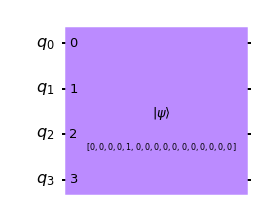

In [33]:
qc=q.QuantumCircuit(n)
qc.initialize(norm_sv)
qc.draw('mpl')

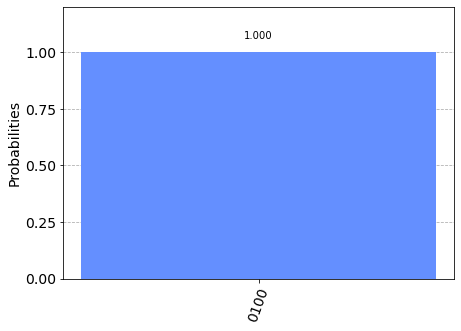

[0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


In [34]:
simulator = q.Aer.get_backend('statevector_simulator')
result = q.execute(qc, simulator).result()
counts=result.get_counts()
plot=q.visualization.plot_histogram(counts)
display(plot)
statevector = result.get_statevector()
print(statevector)